# ELG7186 - Winter 2022 - Assignment 3
## Due: <strong>Monday March 21<sup>st</sup> 2022 -- 11:59pm</strong>

In this assignment, you will apply your knowledge of CNNs we want to estimate the growth stage of weeds using the number of leaves of the plant. The more leaves, the more the weed has grown.

The purpose of this assignment is to gain experience building and training neural networks. You will gain:
- More experience training CNNs
- Experience with problem reformulation
- Experience with techniques for improving results (Regularization, Data Augmentation)

You must use Keras with the Tensorflow backend, i.e., the package tensorflow.keras. For this assignment, you may use other tensorflow packages and scikit-learn, scikit-image or pandas but not other deep learning frameworks, e.g., pytorch, mxnet etc.

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


### DO NOT submit any images from the dataset

## Part 0. Data Preparation

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> (Required files are posted on Brightspace)

However, you must work with the subset of images posted on BrightSpace as training.zip and testing.zip. There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


### Import Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib 
from functools import partial
import os
from skimage import io
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import random
import numpy as np
import tensorflow as tf
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

#### Download the Dataset

In [ ]:
train_data = pathlib.Path('dataset/training') 
test_data = pathlib.Path('dataset/testing')

load_split = partial(
    image_dataset_from_directory,
    train_data,
    validation_split=0.20,
    shuffle=True,
    seed=123,
    image_size=(128, 128),
    batch_size=16,
    labels='inferred',
    label_mode='int')

train_data_128 = load_split(subset='training')
valid_data_128 = load_split(subset='validation')

test_data_128 = image_dataset_from_directory('dataset/testing',
                                            batch_size=16,
                                            image_size=(128,128),
                                            labels='inferred',
                                            label_mode= 'int'
                                            )

Found 900 files belonging to 5 classes.
Using 720 files for training.
Found 900 files belonging to 5 classes.
Using 180 files for validation.
Found 100 files belonging to 5 classes.


#### Visualize five images from the dataset

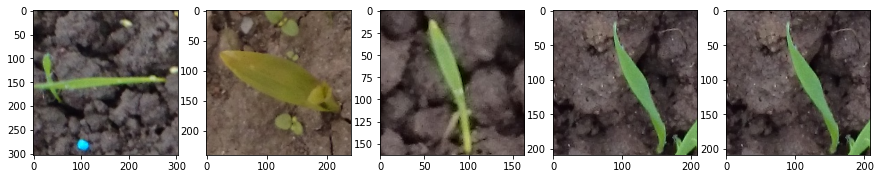

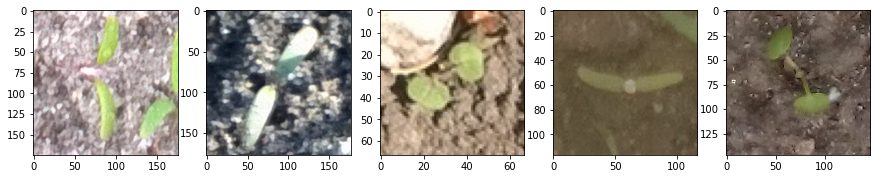

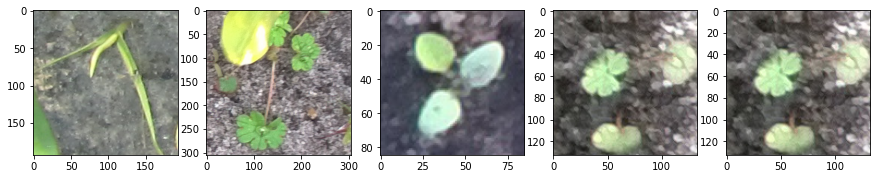

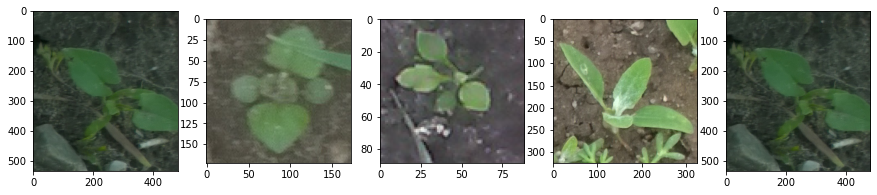

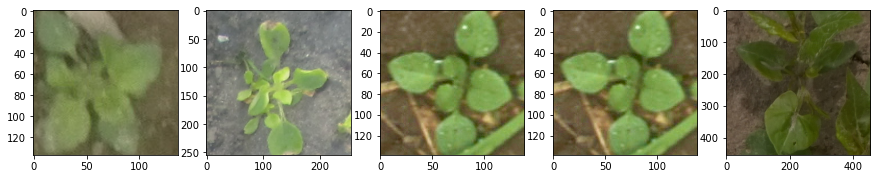

In [ ]:
path = 'dataset/testing'
img_folders = os.listdir(path)
for i in img_folders:
    images_path = os.path.join(path , i)
    fig , axs = plt.subplots(1, 5, figsize = (15 ,10))
    for ax in axs:
        fname = os.listdir(images_path)
        ran = fname[random.randint(0 ,len(fname)-1)]
        pic = io.imread(os.path.join(images_path , ran))
        ax.imshow(pic)
plt.show()

## Part 1a. Transfer Learning - Classification Network (3 Marks)
For this assignment, you are asked to use the Keras implementation of VGG-16 as a starting point. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer. 

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


#### Helper Methods

In [ ]:
def map_preds (preds_list):
    y_pred = []
    for i in preds_list:
        if i <= 1:
            y_pred.append(1)
        elif i> 1 and i< 1.5:
            y_pred.append(1)
        elif i> 1.5 and i< 2:
            y_pred.append(2)
        elif i> 2 and i< 2.5:
            y_pred.append(2)
        elif i> 2.5 and i< 3:
            y_pred.append(3)
        elif i> 3 and i< 3.5:
            y_pred.append(3)
        elif i> 3.5 and i< 4:
            y_pred.append(4)
        elif i> 4 and i< 4.5:
            y_pred.append(4)
        elif i> 4.5 and i< 5:
            y_pred.append(6)
        elif i> 5 and i< 5.5:
            y_pred.append(6)
        elif i> 5.5 and i< 6:
            y_pred.append(6)
        else:
            y_pred.append(6)
    return np.array(y_pred)

In [ ]:
def map_labels(labels):
    new_labels = []
    for i in labels:
        if i==0:
            new_labels.append(1)
        elif i==1:
            new_labels.append(2)
        elif i==2:
            new_labels.append(3)
        elif i==3:
            new_labels.append(4)
        elif i==4:
            new_labels.append(6)
    return np.array(new_labels)

In [ ]:
def get_y_true(batch_data):
    y_true = []
    for x,y in batch_data:
        y_true.append(y)
    y_true = tf.concat(y_true, axis=0)
    return np.array(y_true)

### VGG-16 Architecture Diagram

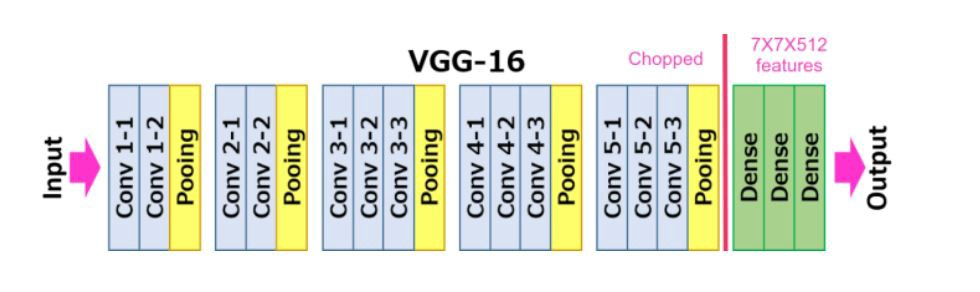

#### Model building

In [4]:
base_vgg = applications.vgg16.VGG16(weights = "imagenet", include_top = False , input_shape = (128, 128, 3))
base_vgg.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model1 = Sequential()
for layer in base_vgg.layers[0:7]:
    model1.add(layer)

model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model1.add(Dense(512, activation='relu'))

model1.add(Flatten())
model1.add(Dense(5, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 256)       2

In [ ]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Training 

In [ ]:
%%time
history = model1.fit_generator(train_data_128,
                              steps_per_epoch=len(train_data_128),
                              epochs=50,
                              verbose=1,
                              validation_data= valid_data_128)

Epoch 1/50
45/45 [==============================] - 18s 389ms/step - loss: 260.0967 - accuracy: 0.2056 - val_loss: 2.1454 - val_accuracy: 0.2000
Epoch 2/50
45/45 [==============================] - 18s 396ms/step - loss: 1.8204 - accuracy: 0.2403 - val_loss: 1.7035 - val_accuracy: 0.2111
Epoch 3/50
45/45 [==============================] - 19s 412ms/step - loss: 1.5540 - accuracy: 0.3194 - val_loss: 2.0210 - val_accuracy: 0.2167
Epoch 4/50
45/45 [==============================] - 19s 429ms/step - loss: 1.4399 - accuracy: 0.4000 - val_loss: 1.7704 - val_accuracy: 0.2056
Epoch 5/50
45/45 [==============================] - 19s 420ms/step - loss: 1.2379 - accuracy: 0.5153 - val_loss: 1.6136 - val_accuracy: 0.2611
Epoch 6/50
45/45 [==============================] - 19s 418ms/step - loss: 1.0852 - accuracy: 0.5694 - val_loss: 1.7255 - val_accuracy: 0.3333
Epoch 7/50
45/45 [==============================] - 19s 425ms/step - loss: 0.9111 - accuracy: 0.6500 - val_loss: 1.7336 - val_accuracy: 0.33

#### Plot a loss curve for training and validation data

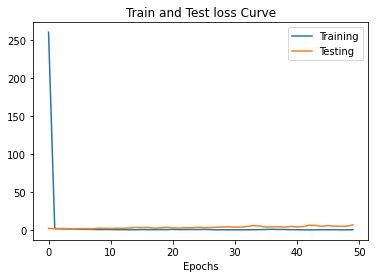

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test loss Curve')
plt.xlabel('Epochs');

#### Plot an accuracy curve for training and validation data

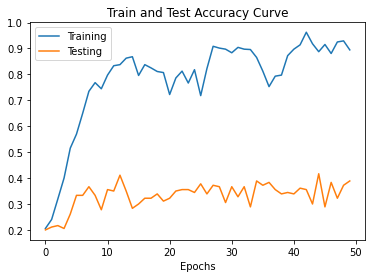

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test Accuracy Curve')
plt.xlabel('Epochs');

#### Plot confusion matrix on testing data

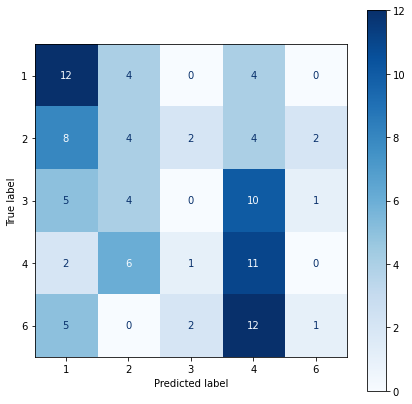

In [ ]:
y_test = []
y_pred = []
for x,y in test_data_128:
    y_test.append(y)
    y_pred.append(tf.argmax(model1.predict(x),axis = 1))
y_pred = tf.concat(y_pred, axis=0)
y_test = tf.concat(y_test, axis=0)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_128.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

#### Plot confusion matrix on validation data

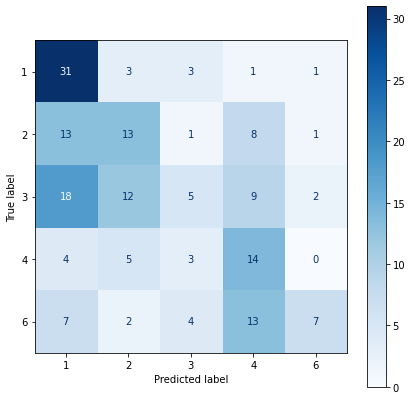

In [ ]:
y_test = []
y_pred = []
for x,y in valid_data_128:
    y_test.append(y)
    y_pred.append(tf.argmax(model1.predict(x),axis = 1))
y_pred = tf.concat(y_pred, axis=0)
y_test = tf.concat(y_test, axis=0)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_data_128.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Part 1b. Transfer Learning - Regression Reformulation (3 Marks)

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

#### Step 1 Reformulate as a regression problem

##### Model building

In [ ]:
model2 = Sequential()
for layer in base_vgg.layers[0:7]:
    model2.add(layer)

model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Dense(512, activation='relu'))
model2.add(Flatten())

model2.add(Dense(1, activation='LeakyReLU'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 256)      

In [ ]:
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mean_squared_error'])

##### Training 

In [ ]:
%%time
history2 = model2.fit_generator(train_data_128,
                              steps_per_epoch=len(train_data_128),
                              epochs=50,
                              verbose=1,
                              validation_data= valid_data_128)

Epoch 1/50
45/45 [==============================] - 18s 392ms/step - loss: 49165.0391 - accuracy: 0.2014 - mean_squared_error: 49165.0391 - val_loss: 57.4472 - val_accuracy: 0.2167 - val_mean_squared_error: 57.4472
Epoch 2/50
45/45 [==============================] - 18s 398ms/step - loss: 45.1686 - accuracy: 0.1931 - mean_squared_error: 45.1686 - val_loss: 33.4433 - val_accuracy: 0.2111 - val_mean_squared_error: 33.4433
Epoch 3/50
45/45 [==============================] - 18s 409ms/step - loss: 28.2827 - accuracy: 0.2014 - mean_squared_error: 28.2827 - val_loss: 28.6237 - val_accuracy: 0.2111 - val_mean_squared_error: 28.6237
Epoch 4/50
45/45 [==============================] - 18s 399ms/step - loss: 24.6505 - accuracy: 0.2167 - mean_squared_error: 24.6505 - val_loss: 18.0841 - val_accuracy: 0.2000 - val_mean_squared_error: 18.0841
Epoch 5/50
45/45 [==============================] - 19s 417ms/step - loss: 13.4567 - accuracy: 0.1833 - mean_squared_error: 13.4567 - val_loss: 11.8171 - val_

Epoch 41/50
45/45 [==============================] - 20s 437ms/step - loss: 0.7624 - accuracy: 0.2944 - mean_squared_error: 0.7624 - val_loss: 5.3389 - val_accuracy: 0.1833 - val_mean_squared_error: 5.3389
Epoch 42/50
45/45 [==============================] - 20s 435ms/step - loss: 0.8174 - accuracy: 0.2972 - mean_squared_error: 0.8174 - val_loss: 5.2609 - val_accuracy: 0.2000 - val_mean_squared_error: 5.2609
Epoch 43/50
45/45 [==============================] - 19s 428ms/step - loss: 0.6777 - accuracy: 0.2792 - mean_squared_error: 0.6777 - val_loss: 6.8514 - val_accuracy: 0.2000 - val_mean_squared_error: 6.8514
Epoch 44/50
45/45 [==============================] - 18s 410ms/step - loss: 0.8749 - accuracy: 0.2986 - mean_squared_error: 0.8749 - val_loss: 5.4628 - val_accuracy: 0.2056 - val_mean_squared_error: 5.4628
Epoch 45/50
45/45 [==============================] - 18s 399ms/step - loss: 1.0437 - accuracy: 0.2806 - mean_squared_error: 1.0437 - val_loss: 5.0915 - val_accuracy: 0.2278 - v

##### Plot a loss curve for training and validation data

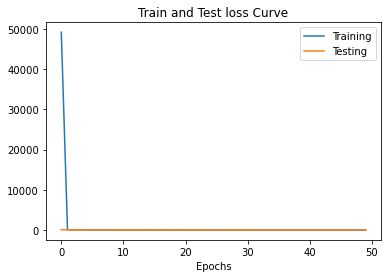

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test loss Curve')
plt.xlabel('Epochs');

##### Plot an accuracy curve for training and validation data

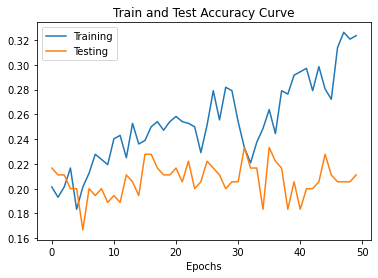

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test Accuracy Curve')
plt.xlabel('Epochs');

##### Plot confusion matrix on test data

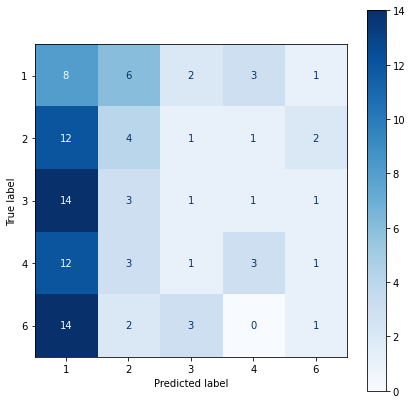

In [ ]:
preds = model2.predict(test_data_128)
y_pred2 = map_preds(preds)
y_test = map_labels(get_y_true(test_data_128))

cm2 = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=test_data_128.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

##### Plot confusion matrix on validation data

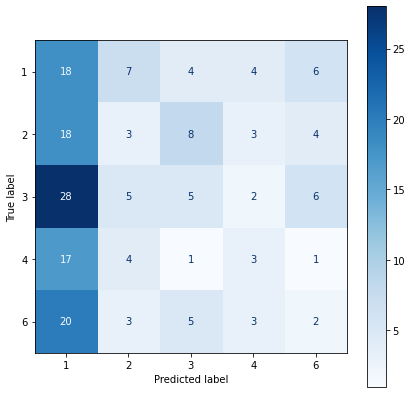

In [ ]:
preds = model2.predict(valid_data_128)
y_pred2 = map_preds(preds)
y_test = map_labels(get_y_true(valid_data_128))

cm2 = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=valid_data_128.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

#### Step 2 Discussion

**part 1 a:**
- The training accuracy was **0.8944**, whereas the validation accuracy was **0.3889**, and the training loss was **0.3719**, whereas the validation loss was **6.7928**.
- We can see that there was a large gap between the training and validation curves in both accuracy and loss when looking at the loss and accuracy curves.
- As a result of our model's inability to generalise, the confusion matrix on the testing data did not produce satisfactory results.

**part 1 b:**
- The training MSE was **0.5056**, whereas the validation MSE was **4.9731**, training accuracy was **0.3236** and validation accuracy was **0.2111**  .
- We can see that there was a large gap between the training and validation curves in both accuracy and loss when looking at the accuracy and MSE curves.
- The regression produced very poor accuracy for this problem, as indicated in the confusion matrixes. 

---
 ***We may conclude from this experiment that overfitting happened since the training data was small and our model was more complicated, we will handle this in the next part***
 
---





## Part 2. Improve your Model (4 Marks)

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1 (1.5)
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.
 

### Step 2 (1.5)
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.

### Step 3 (1)
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

#### Step 1  Add Batch Normalization and Dropout

##### Model building

In [5]:
model3 = Sequential()
for layer in base_vgg.layers[0:7]:
    model3.add(layer)

model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model3.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(5, activation='softmax'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      5

In [ ]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

##### Training 

In [ ]:
%%time
history3 = model3.fit_generator(train_data_128,
                              steps_per_epoch=len(train_data_128),
                              epochs=30,
                              verbose=1,
                              validation_data= valid_data_128)

Epoch 1/30
45/45 [==============================] - 26s 571ms/step - loss: 2.6637 - accuracy: 0.2639 - val_loss: 12.2303 - val_accuracy: 0.1778
Epoch 2/30
45/45 [==============================] - 24s 540ms/step - loss: 2.6674 - accuracy: 0.3250 - val_loss: 4.7091 - val_accuracy: 0.2500
Epoch 3/30
45/45 [==============================] - 26s 571ms/step - loss: 2.4521 - accuracy: 0.3806 - val_loss: 2.6864 - val_accuracy: 0.3833
Epoch 4/30
45/45 [==============================] - 25s 549ms/step - loss: 2.2831 - accuracy: 0.4278 - val_loss: 1.8326 - val_accuracy: 0.4667
Epoch 5/30
45/45 [==============================] - 25s 565ms/step - loss: 2.3480 - accuracy: 0.4361 - val_loss: 1.9015 - val_accuracy: 0.4111
Epoch 6/30
45/45 [==============================] - 28s 623ms/step - loss: 2.0103 - accuracy: 0.4903 - val_loss: 1.8464 - val_accuracy: 0.5000
Epoch 7/30
45/45 [==============================] - 25s 546ms/step - loss: 1.8796 - accuracy: 0.5042 - val_loss: 1.7992 - val_accuracy: 0.533

##### Plot a loss curve for training and validation data

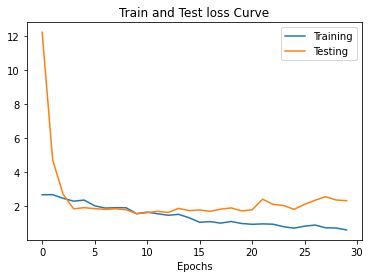

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test loss Curve')
plt.xlabel('Epochs');

##### Plot an accuracy curve for training and validation data

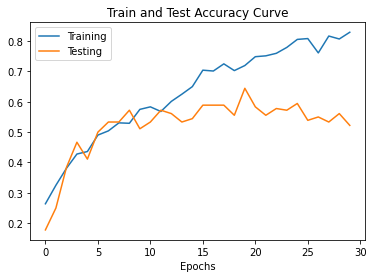

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test Accuracy Curve')
plt.xlabel('Epochs');

##### Plot confusion matrix on testing data

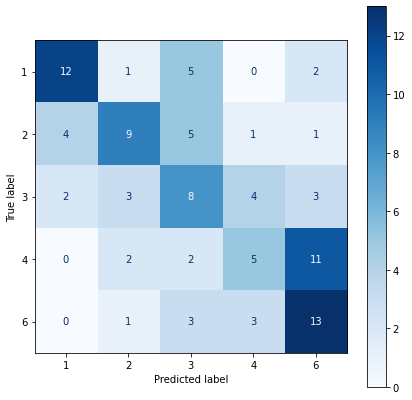

In [ ]:
y_test = []
y_pred3 = []
for x,y in test_data_128:
    y_test.append(y)
    y_pred3.append(tf.argmax(model3.predict(x),axis = 1))
y_pred3 = tf.concat(y_pred3, axis=0)
y_test = tf.concat(y_test, axis=0)

cm3 = confusion_matrix(y_test, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=test_data_128.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

##### Plot confusion matrix on validation data

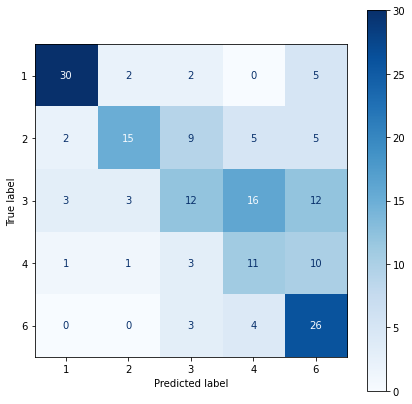

In [ ]:
y_test = []
y_pred3 = []
for x,y in valid_data_128:
    y_test.append(y)
    y_pred3.append(tf.argmax(model3.predict(x),axis = 1))
y_pred3 = tf.concat(y_pred3, axis=0)
y_test = tf.concat(y_test, axis=0)

cm3 = confusion_matrix(y_test, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=valid_data_128.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

#### Step 2 Add Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
                                     rotation_range=90,               
                                     brightness_range=[0.1, 0.7],        
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.20,
                                     fill_mode = 'nearest',
                                     rescale=1./255
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

train_iterator_128 = train_datagen.flow_from_directory(
                                                    'dataset/training',
                                                    target_size=(128,128),
                                                    batch_size=16,
                                                    class_mode='sparse',
                                                    subset='training',
                                                    )

valid_iterator_128 = train_datagen.flow_from_directory(
                                                    'dataset/training',
                                                    target_size=(128,128),
                                                    batch_size=16,
                                                    class_mode='sparse',
                                                    subset='validation',
                                                    )
test_iterator_128 = test_datagen.flow_from_directory(
                                                    'dataset/testing',
                                                    target_size=(128,128),
                                                    batch_size=16,
                                                    class_mode='sparse'
                                                    )

Found 720 images belonging to 5 classes.
Found 180 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


##### Model Building

In [6]:
model4 = Sequential()
for layer in base_vgg.layers[0:7]:
    model4.add(layer)

model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model4.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))

model4.add(Flatten())
model4.add(Dense(5, activation='softmax'))

model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0         
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 128)     

In [ ]:
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

##### Training 

In [ ]:
%%time
history4 = model4.fit_generator(train_iterator_128,
                              steps_per_epoch=len(train_iterator_128),
                              epochs=100,
                              verbose=1,
                              validation_data= valid_iterator_128)

Epoch 1/100
45/45 [==============================] - 22s 485ms/step - loss: 2.8405 - accuracy: 0.2153 - val_loss: 19.2757 - val_accuracy: 0.2000
Epoch 2/100
45/45 [==============================] - 24s 526ms/step - loss: 2.6134 - accuracy: 0.2417 - val_loss: 9.3144 - val_accuracy: 0.1722
Epoch 3/100
45/45 [==============================] - 23s 518ms/step - loss: 2.5991 - accuracy: 0.2583 - val_loss: 10.2597 - val_accuracy: 0.2056
Epoch 4/100
45/45 [==============================] - 24s 541ms/step - loss: 2.8684 - accuracy: 0.2736 - val_loss: 3.2541 - val_accuracy: 0.2778
Epoch 5/100
45/45 [==============================] - 24s 536ms/step - loss: 2.5506 - accuracy: 0.2681 - val_loss: 3.5553 - val_accuracy: 0.2444
Epoch 6/100
45/45 [==============================] - 24s 527ms/step - loss: 2.5263 - accuracy: 0.2986 - val_loss: 5.1353 - val_accuracy: 0.3111
Epoch 7/100
45/45 [==============================] - 24s 528ms/step - loss: 2.4799 - accuracy: 0.2736 - val_loss: 5.7007 - val_accurac

##### Plot a loss curve for training and validation data

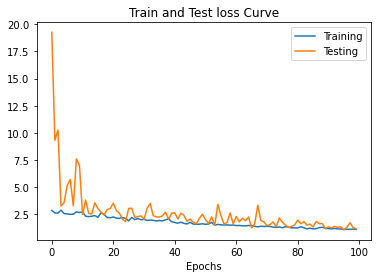

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test loss Curve')
plt.xlabel('Epochs');

##### Plot an accuracy curve for training and validation data

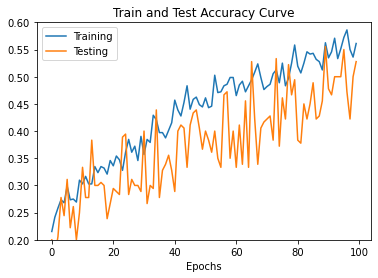

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.legend(['Training', 'Testing'])
plt.title('Train and Test Accuracy Curve')
plt.ylim(0.2,0.6)
plt.xlabel('Epochs');

##### Plot confusion matrix on testing data

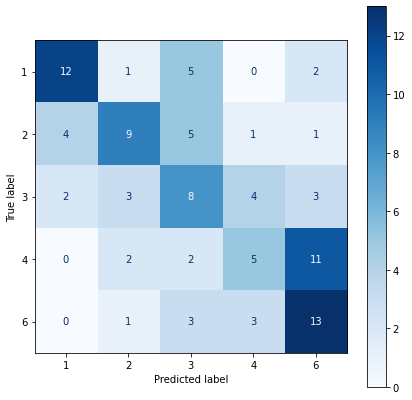

In [ ]:
y_test = []
y_pred4 = []
for x,y in test_data_128:
    y_test.append(y)
    y_pred4.append(tf.argmax(model3.predict(x),axis = 1))
y_pred4 = tf.concat(y_pred4, axis=0)
y_test = tf.concat(y_test, axis=0)

cm4 = confusion_matrix(y_test, y_pred4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=test_data_128.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

##### Plot confusion matrix on validation data

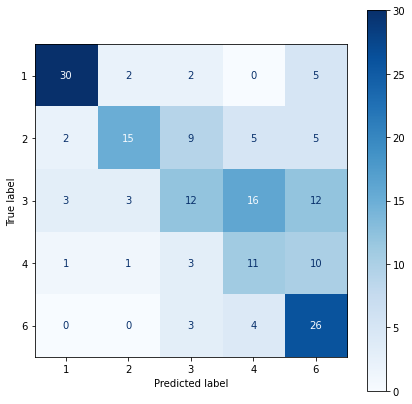

In [ ]:
y_test = []
y_pred4 = []
for x,y in valid_data_128:
    y_test.append(y)
    y_pred4.append(tf.argmax(model3.predict(x),axis = 1))
y_pred4 = tf.concat(y_pred4, axis=0)
y_test = tf.concat(y_test, axis=0)

cm4 = confusion_matrix(y_test, y_pred4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=valid_data_128.class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

#### Step 3 Discussion

**Step 1:**
- By adding additional dropout and batch normalization layers to our model, we were able to handle the overfit problem from part 1.
- the effect of dropout During training, the network's capacity is reduced or it is thinned. and the effect of batch normalization For each mini-batch, uniformizes the inputs to a layer. This stabilises the learning process while drastically lowering the number of training epochs needed to create deep networks.
- The results of adding these two layers to our model were that the gap between training and validation got less wider than in part 1 (as demonstrated by the accuracy and loss curves).
- Training accuracy was **0.8292**, whereas validation accuracy was **0.5222**, and training loss was **0.5918**, whilst validation loss was **2.3115**.
- Both the test and validation confusion matrixes showed an improvement from previous matrixes in part 1.

**Step 2:**
- Because our dataset was insufficient for the model to learn, we added image augmentation to our images in this section.
-  Flipping, translation, rotation, scaling, and brightness changes were some of the image augmentation techniques we used.
- Training accuracy was **0.5611**, whereas validation accuracy was **0.5278**, and training loss was **1.0855**, whilst validation loss was **1.1431**.
- We can see that the gap between training and validation has narrowed since step 1 (as demonstrated by the accuracy and loss curves).
- It's a huge improvement to overcome the overfitting, although the model's accuracy in step 2 is lower than in step 1 and part 1, the model has learned and can now generalize well, as evidenced by the testing and validation confusion matrixes in step 2.
- The test and validation confusion matrixes both produced excellent results when compared to the prior matrixes in part 1 and step 1.

---
 ***We may conclude from this experiment that we can overcome overfitting by using regularization techniques like dropout and batch normalization, as well as data augmentation approaches to expand the dataset size.***
 
---




## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.